In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F

In [0]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()
        if pad is None: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [0]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nc, ndf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        self.initial = ConvBlock(nc, ndf, 4, 2, bn=False)
        csize,cndf = isize/2,ndf
        self.extra = nn.Sequential(*[ConvBlock(cndf, cndf, 3, 1)
                                    for t in range(n_extra_layers)])

        pyr_layers = []
        while csize > 4:
            pyr_layers.append(ConvBlock(cndf, cndf*2, 4, 2))
            cndf *= 2; csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)

    def forward(self, input):
        x = self.initial(input)
        x = self.extra(x)
        x = self.pyramid(x)
        return self.final(x).mean(0).view(1)

In [0]:
class DeconvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, pad, bn=True):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [0]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize!=isize: cngf*=2; tisize*=2
        layers = [DeconvBlock(nz, cngf, 4, 1, 0)]

        csize, cndf = 4, cngf
        while csize < isize//2:
            layers.append(DeconvBlock(cngf, cngf//2, 4, 2, 1))
            cngf //= 2; csize *= 2

        layers += [DeconvBlock(cngf, cngf, 3, 1, 1) for t in range(n_extra_layers)]
        layers.append(nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        self.features = nn.Sequential(*layers)

    def forward(self, input): return F.tanh(self.features(input))

In [0]:
bs,sz,nz = 64,64,100

In [0]:
netG = DCGAN_G(sz, nz, 3, 64, 1).cuda()
netD = DCGAN_D(sz, 3, 64, 1).cuda()

In [0]:
from distutils.version import LooseVersion
USE_GPU = torch.cuda.is_available()
IS_TORCH_04 = LooseVersion(torch.__version__) >= LooseVersion('0.4')
def to_gpu(x, *args, **kwargs):
    '''puts pytorch variable to gpu, if cuda is available and USE_GPU is set to true. '''
    return x.cuda(*args, **kwargs) if USE_GPU else x

def T(a, half=False, cuda=True):
    """
    Convert numpy array into a pytorch tensor. 
    if Cuda is available and USE_GPU=True, store resulting tensor in GPU.
    """
    if not torch.is_tensor(a):
        a = np.array(np.ascontiguousarray(a))
        if a.dtype in (np.int8, np.int16, np.int32, np.int64):
            a = torch.LongTensor(a.astype(np.int64))
        elif a.dtype in (np.float32, np.float64):
            a = to_half(a) if half else torch.FloatTensor(a)
        else: raise NotImplementedError(a.dtype)
    if cuda: a = to_gpu(a)
    return a

def map_over(x, f): return [f(o) for o in x] if is_listy(x) else f(x)
def is_listy(x): return isinstance(x, (list,tuple))
def create_variable(x, volatile, requires_grad=False):
    if type (x) != torch.autograd.Variable:
        if IS_TORCH_04: x = torch.autograd.Variable(T(x), requires_grad=requires_grad)
        else:           x = torch.autograd.Variable(T(x), requires_grad=requires_grad, volatile=volatile)
    return x

def V(x, requires_grad=False, volatile=False):
    '''creates a single or a list of pytorch tensors, depending on input x. '''
    return map_over(x, lambda o: V_(o, requires_grad, volatile))

def V_(x, requires_grad=False, volatile=False):
    '''equivalent to create_variable, which creates a pytorch tensor'''
    return create_variable(x, volatile=volatile, requires_grad=requires_grad)


In [0]:
netG = DCGAN_G(sz, nz, 3, 64, 1).cuda()
netD = DCGAN_D(sz, 3, 64, 1).cuda()

In [0]:
dec = nn.Sequential(*children(netD)[:-1]+[nn.Conv2d(512,100,4,bias=False)]).cuda()

In [0]:
autoenc = (nn.Sequential(dec,netG)).cuda()

In [22]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)
%cd "/content/drive/My Drive/automatic-asset-classification"
%ls "/content/drive/My Drive/automatic-asset-classification"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/automatic-asset-classification
ae_res_1_new    ae_res_3_new    ae_res_4_torch  ae_res_6_torch
ae_res_1_torch  ae_res_3_torch  ae_res_5_new    data/
ae_res_2_new    ae_res_4_new    ae_res_5_torch  final_model
ae_res_2_torch  ae_res_4-new    ae_res_6_new    models/


In [0]:
np.random.seed(3333)
torch.manual_seed(3333)
image_path = "/content/drive/My Drive/automatic-asset-classification/data/final_dataset"
size = 64
batchsize = 32

tfms = get_transforms(do_flip = True)
src = (ImageImageList.from_folder(image_path).split_by_rand_pct().label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))

In [24]:
data

ImageDataBunch;

Train: LabelList (387 items)
x: ImageImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
Path: /content/drive/My Drive/automatic-asset-classification/data/final_dataset;

Valid: LabelList (96 items)
x: ImageImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
Path: /content/drive/My Drive/automatic-asset-classification/data/final_dataset;

Test: None

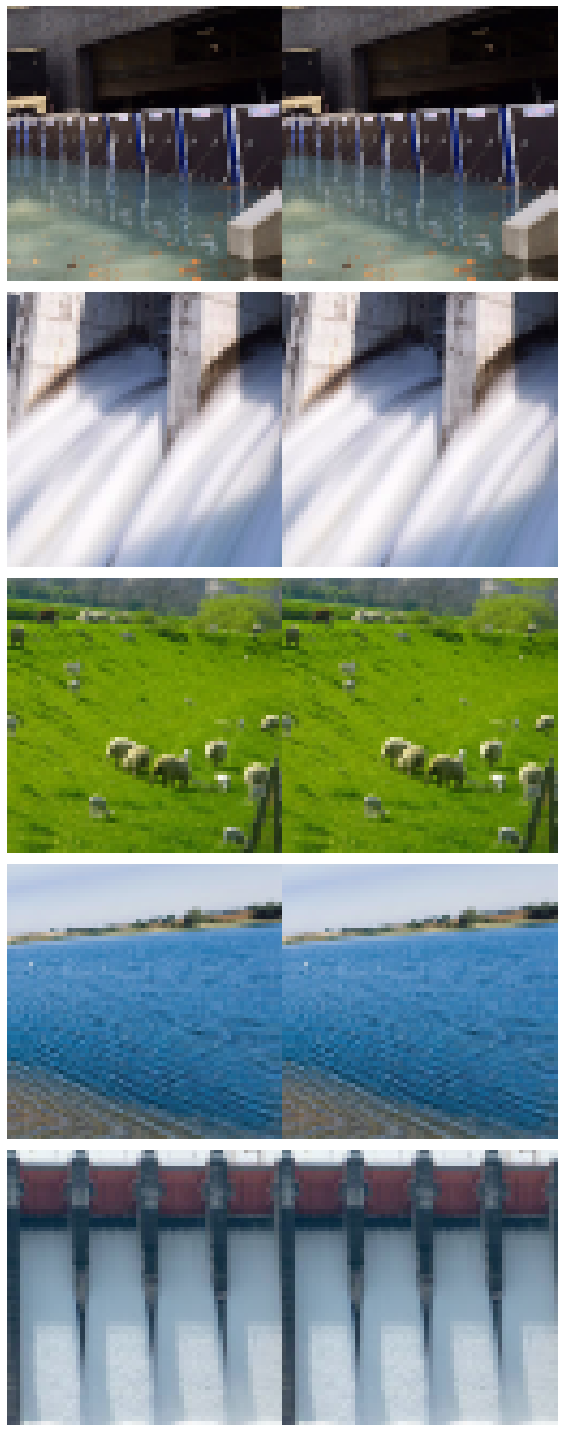

In [25]:
data.show_batch(nrows = 1)

In [0]:
class reshape(nn.Module):
  def __init__(self, shape):
      super(reshape, self).__init__()
      self.shape = shape
  def forward(self, x): return x.reshape(self.shape)

In [0]:
class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = (2,2), stride = (2,2)),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(16),
            nn.BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(24 * 16 * 16, 1568)
        )

        self.decoder = nn.Sequential(
            nn.Linear(1568, 24 * 16 * 16),
            reshape([-1,24,16,16]),
            nn.Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.Upsample(scale_factor = 2, mode ='bilinear',align_corners=True),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.Upsample(scale_factor = 2, mode ='bilinear', align_corners=True),
            nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )
        
    def encode(self,x): return self.encoder(x)
    
    def decode(self,x): return torch.clamp(self.decoder(x), min = 0, max=1)
        

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return torch.clamp(decoded, min=0, max=1)

In [0]:
ae = Autoencoder()

In [0]:
learn = Learner(data, ae, loss_func = F.mse_loss)

In [96]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.172394,0.161178,01:43


In [97]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.134122,#na#,00:12
1,0.133068,#na#,00:12
2,0.132339,#na#,00:12
3,0.127126,#na#,00:12
4,0.114373,#na#,00:12
5,0.101525,#na#,00:11
6,0.091022,#na#,00:12
7,0.082417,#na#,00:12


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.02E-03
Min loss divided by 10: 3.31E-01


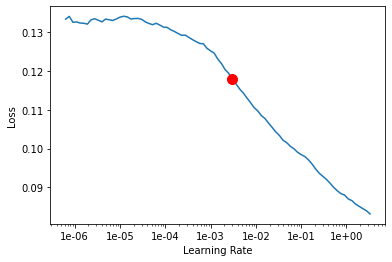

In [98]:
learn.recorder.plot(suggestion = True)

In [99]:
learn.fit_one_cycle(20, max_lr = 1e-01)

epoch,train_loss,valid_loss,time
0,0.086145,0.237278,00:16
1,0.070804,0.190574,00:16
2,0.061996,0.096566,00:16
3,0.055158,0.098460,00:16
4,0.050089,0.074216,00:16
5,0.045826,0.048106,00:16
6,0.046298,0.113276,00:16
7,0.043292,0.079383,00:15
8,0.040336,0.035573,00:16
9,0.037282,0.026594,00:16


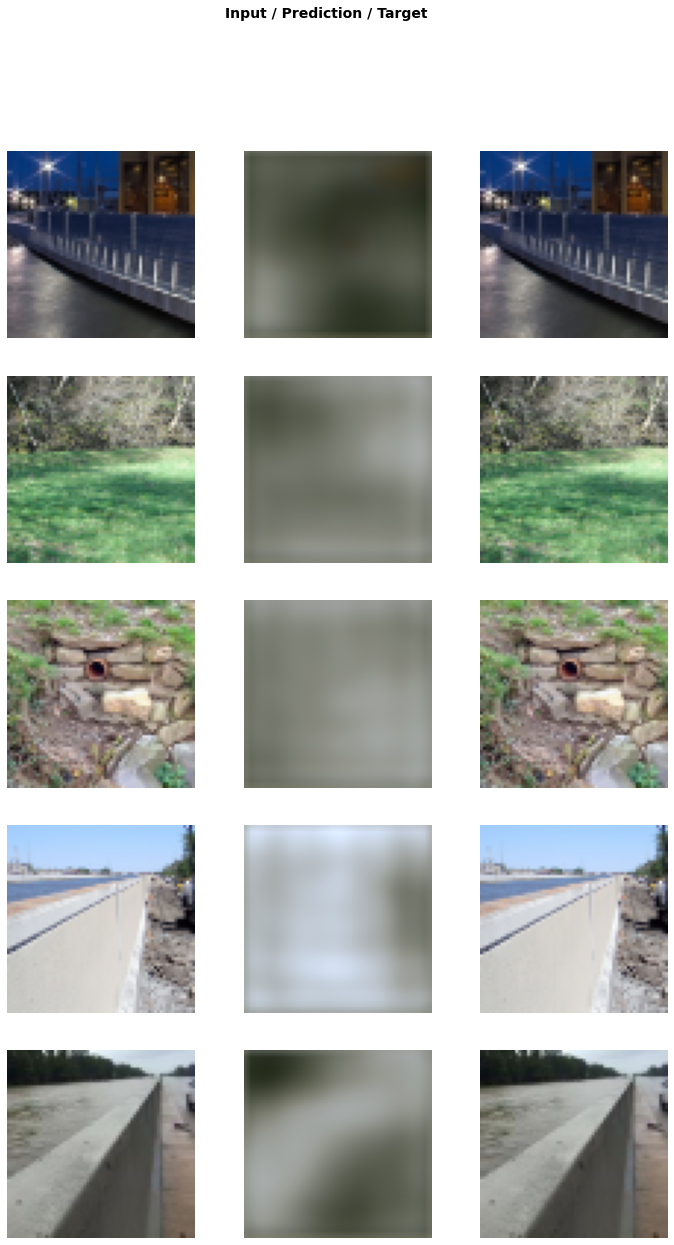

In [100]:
learn.show_results()

In [101]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.021024,#na#,00:13
1,0.021103,#na#,00:12
2,0.021083,#na#,00:13
3,0.021039,#na#,00:12
4,0.021008,#na#,00:13
5,0.021233,#na#,00:12
6,0.021782,#na#,00:12
7,0.036495,#na#,00:12


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-06
Min loss divided by 10: 1.58E-07


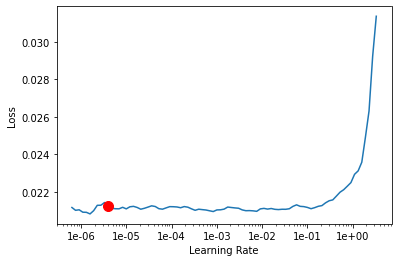

In [102]:
learn.recorder.plot(suggestion = True)

In [103]:
learn.fit_one_cycle(50, max_lr = 1e-02)

epoch,train_loss,valid_loss,time
0,0.021168,0.021206,00:17
1,0.021162,0.021212,00:16
2,0.021129,0.021201,00:16
3,0.021153,0.021133,00:16
4,0.021027,0.021159,00:16
5,0.020948,0.021100,00:17
6,0.020895,0.021061,00:17
7,0.020981,0.020964,00:16
8,0.020967,0.020964,00:16
9,0.021039,0.020793,00:16


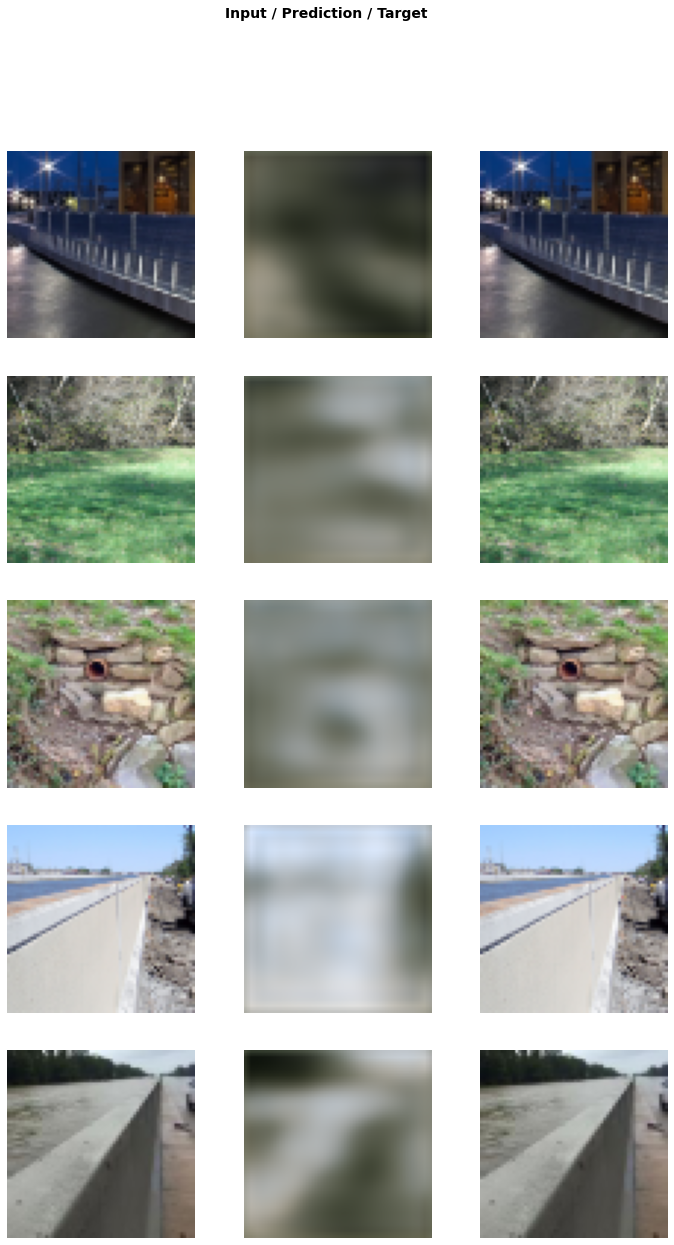

In [110]:
learn.show_results()

In [0]:
def icnr(x, scale=2, init=nn.init.kaiming_normal_):
    "ICNR init of `x`, with `scale` and `init` function."
    ni,nf,h,w = x.shape
    ni2 = int(ni/(scale**2))
    k = init(torch.zeros([ni2,nf,h,w])).transpose(0, 1)
    k = k.contiguous().view(ni2, nf, -1)
    k = k.repeat(1, 1, scale**2)
    k = k.contiguous().view([nf,ni,h,w]).transpose(0, 1)
    x.data.copy_(k)

class PixelShuffle_ICNR(nn.Module):
    "Upsample by `scale` from `ni` filters to `nf` (default `ni`), using `nn.PixelShuffle`, `icnr` init, and `weight_norm`."
    def __init__(self, ni:int, nf:int=None, scale:int=2, blur:bool=False, norm_type=NormType.Weight, leaky:float=None):
        super().__init__()
        nf = ifnone(nf, ni)
        self.conv = conv_layer(ni, nf*(scale**2), ks=1, norm_type=norm_type, use_activ=False)
        icnr(self.conv[0].weight)
        self.shuf = nn.PixelShuffle(scale)
        # Blurring over (h*w) kernel
        # "Super-Resolution using Convolutional Neural Networks without Any Checkerboard Artifacts"
        # - https://arxiv.org/abs/1806.02658
        self.pad = nn.ReplicationPad2d((1,0,1,0))
        self.blur = nn.AvgPool2d(2, stride=1)
        self.relu = relu(True, leaky=leaky)

    def forward(self,x):
        x = self.shuf(self.relu(self.conv(x)))
        return self.blur(self.pad(x)) if self.blur else x

In [0]:
class Autoencoder2(nn.Module):

    def __init__(self):
        super(Autoencoder2, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = (2,2), stride = (2,2)),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(16),
            nn.BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(24 * 16 * 16, 1568)
        )

        self.decoder = nn.Sequential(
            nn.Linear(1568, 24 * 16 * 16),
            reshape([-1,24,16,16]),
            nn.Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            PixelShuffle_ICNR(12, 12),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            PixelShuffle_ICNR(12, 3),
            nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )
        
    def encode(self,x): return self.encoder(x)
    
    def decode(self,x): return torch.clamp(self.decoder(x), min = 0, max=1)
        

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return torch.clamp(decoded, min=0, max=1)

In [0]:
ae2 = Autoencoder2()

In [0]:
learn2 = Learner(data, ae2, loss_func = F.mse_loss)

In [109]:
learn2.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.205199,0.252630,00:16


In [112]:
learn2.lr_find()

epoch,train_loss,valid_loss,time
0,0.187022,#na#,00:13
1,0.187798,#na#,00:11
2,0.187740,#na#,00:13
3,0.185844,#na#,00:13
4,0.181386,#na#,00:12
5,0.172059,#na#,00:13
6,0.148875,#na#,00:12
7,0.134758,#na#,00:12


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-01
Min loss divided by 10: 3.31E-01


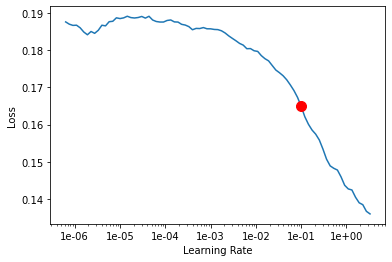

In [113]:
learn2.recorder.plot(suggestion = True)

In [114]:
learn2.fit_one_cycle(50, max_lr = 1e-01)

epoch,train_loss,valid_loss,time
0,0.174212,0.174105,00:17
1,0.161348,0.193447,00:17
2,0.146147,0.170128,00:17
3,0.120833,0.102331,00:17
4,0.098071,0.097314,00:17
5,0.080821,0.049034,00:17
6,0.067681,0.043341,00:17
7,0.057645,0.028831,00:16
8,0.049706,0.026539,00:17
9,0.043703,0.025258,00:17


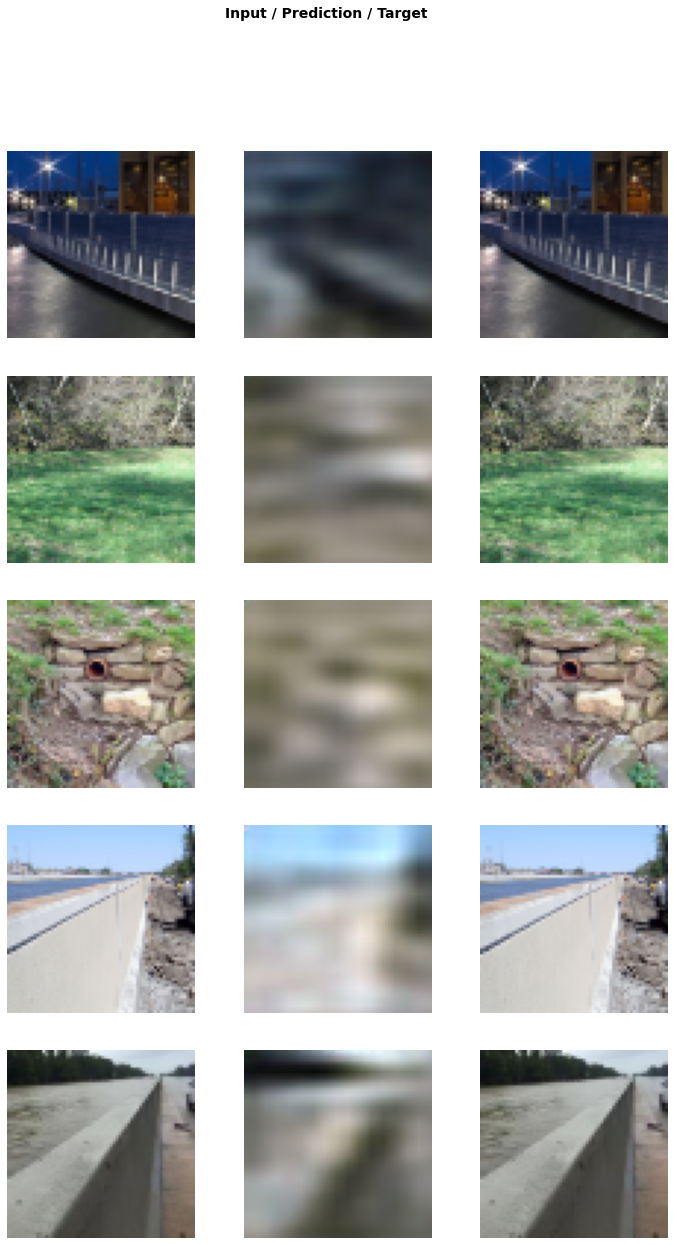

In [115]:
learn2.show_results()

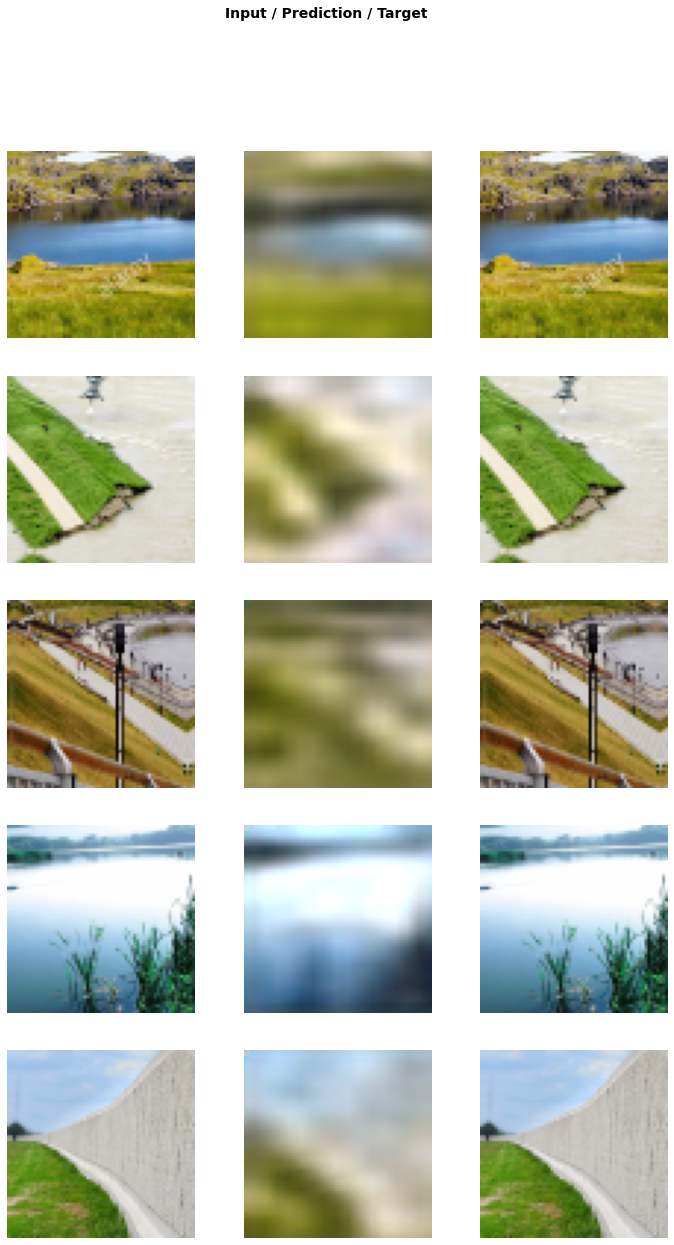

In [116]:
learn2.show_results(ds_type = DatasetType.Train)